In [61]:
%matplotlib inline

In [ ]:
import os, sys
#current_dir = os.getcwd()
#DATA_HOME_DIR =  '/home/denys/projects/ml-models/kaggle/dog-breed-identification/data/'
DATA_HOME_DIR =  '/home/denys/projects/ml-models/kaggle/dog-breed-identification/data/sample/'

In [59]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
labels_df = pd.read_csv("data/labels.csv")

def get_breed(id):
    return labels_df.loc[labels_df["id"] == id]["breed"].values[0]

In [93]:
g = glob(DATA_HOME_DIR + '/train/pomeranian/*.jpg')
len(g)

96

In [ ]:
for i in range(15):
    file_name = g[i][-36:]
    os.rename(g[i], DATA_HOME_DIR + "valid/doberman/" + file_name)

In [ ]:
mv data/sample/valid/*.jpg data/sample/valid/pomeranian/

In [ ]:
mkdir data/sample/valid/doberman

In [4]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam

from keras.regularizers import l2

Using TensorFlow backend.


In [16]:
target_size=(224,224)

def prepare_data(dir_path=DATA_HOME_DIR + 'train', shuffle=False):
    gen = image.ImageDataGenerator()
    batches = gen.flow_from_directory(dir_path, shuffle=shuffle, 
                                            class_mode='categorical', batch_size=1,  target_size=target_size)
    
    img = batches.next()
    
    labels = img[1]
    data = img[0]
    for i in range(batches.samples - 1):
        img = batches.next()
        labels = np.concatenate([labels, img[1]])
        data = np.concatenate([data, img[0]])
    
    filenames = batches.filenames
    class_indices = batches.class_indices
    
    return data, labels, filenames, class_indices

In [8]:
train_data, train_labels, train_filenames, train_class_indices = prepare_data()

In [55]:
valid_path = DATA_HOME_DIR + 'valid/'

In [17]:
valid_data, valid_labels, valid_filenames, valid_class_indices = prepare_data(dir_path=valid_path)

Found 30 images belonging to 2 classes.


In [10]:
model_path = DATA_HOME_DIR + "models/"

In [12]:
def simple_model():
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(224,224, 3)),
            Conv2D(32,(3,3), activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            BatchNormalization(),
            Dense(2, activation='softmax')
        ])
    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [43]:
def train(model, batches, val_batches, initialisation=False):
    if initialisation:
        model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit_generator(batches, steps_per_epoch=batches.n / batch_size, epochs=10, validation_data=val_batches, 
                    validation_steps=val_batches.n, verbose=1, callbacks=[csv_logger])

    model.optimizer.lr = 0.00001
    model.fit_generator(batches, steps_per_epoch=batches.n / batch_size, epochs=100, validation_data=val_batches, 
                        validation_steps=val_batches.n, verbose=1, callbacks=[csv_logger])

In [44]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('training.log')

In [ ]:
kf = KFold(n_splits=3)
kf.get_n_splits(train_data)
print(kf) 

batch_size=15

base_model = simple_model()

init = True
for train_index, valid_index in kf.split(train_data):
    print train_index, valid_index
    train_split, valid_split = train_data[train_index], train_data[valid_index]
    train_labels_split, valid_labels_split = train_labels[train_index], train_labels[valid_index]

    batches = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True).flow(train_split, train_labels_split, batch_size=batch_size, shuffle=True)
    val_batches = image.ImageDataGenerator().flow(valid_split, valid_labels_split, batch_size=batch_size, shuffle=False)
    
    train(base_model, batches, val_batches, init)
    init = False

KFold(n_splits=3, random_state=None, shuffle=False)
[ 52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51]
Epoch 1/10
6/6 [==============================] - 4s 745ms/step - loss: 1.7809 - acc: 0.5327 - val_loss: 5.5662 - val_acc: 0.2692
Epoch 2/10
6/6 [==============================] - 4s 665ms/step - loss: 1.9065 - acc: 0.6333 - val_loss: 0.0094 - val_acc: 1.0000
Epoch 3/10
6/6 [==============================] - 4s 661ms/step - loss: 1.1213 - acc: 0.6612 - val_loss: 4.64

6/6 [==============================] - 4s 661ms/step - loss: 1.5318 - acc: 0.8759 - val_loss: 1.3476 - val_acc: 0.8654
Epoch 6/100
6/6 [==============================] - 4s 662ms/step - loss: 2.7632 - acc: 0.7741 - val_loss: 1.4192 - val_acc: 0.8846
Epoch 7/100
6/6 [==============================] - 4s 661ms/step - loss: 1.9720 - acc: 0.7935 - val_loss: 1.7282 - val_acc: 0.8654
Epoch 8/100
6/6 [==============================] - 4s 662ms/step - loss: 1.5164 - acc: 0.8187 - val_loss: 1.9741 - val_acc: 0.8654
Epoch 9/100
6/6 [==============================] - 4s 662ms/step - loss: 1.8842 - acc: 0.8395 - val_loss: 1.6976 - val_acc: 0.8654
Epoch 10/100
6/6 [==============================] - 4s 666ms/step - loss: 1.4178 - acc: 0.8889 - val_loss: 1.3136 - val_acc: 0.8462
Epoch 11/100
6/6 [==============================] - 4s 658ms/step - loss: 2.0797 - acc: 0.7928 - val_loss: 1.1247 - val_acc: 0.8846
Epoch 12/100
6/6 [==============================] - 4s 665ms/step - loss: 1.3237 - acc: 0.888

6/6 [==============================] - 4s 646ms/step - loss: 0.5751 - acc: 0.9444 - val_loss: 0.3210 - val_acc: 0.9802
Epoch 25/100
6/6 [==============================] - 4s 647ms/step - loss: 1.1022 - acc: 0.8887 - val_loss: 0.3314 - val_acc: 0.9802
Epoch 26/100
6/6 [==============================] - 4s 647ms/step - loss: 1.3010 - acc: 0.9111 - val_loss: 0.2313 - val_acc: 0.9604
Epoch 27/100
6/6 [==============================] - 4s 646ms/step - loss: 0.3766 - acc: 0.9666 - val_loss: 0.1584 - val_acc: 0.9604
Epoch 28/100
6/6 [==============================] - 4s 647ms/step - loss: 1.1114 - acc: 0.8874 - val_loss: 0.1031 - val_acc: 0.9604
Epoch 29/100
6/6 [==============================] - 4s 649ms/step - loss: 0.8845 - acc: 0.9222 - val_loss: 0.0238 - val_acc: 0.9802
Epoch 30/100
6/6 [==============================] - 4s 644ms/step - loss: 0.7542 - acc: 0.9324 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 31/100
6/6 [==============================] - 4s 648ms/step - loss: 0.7674 - acc: 0

In [24]:
base_model.save_weights(model_path[:-len("models/sample/")] + "models/simple_model_sample.weights")

In [ ]:
valid_data, valid_labels, valid_filenames, valid_class_indices 

In [29]:
valid_class_indices

{'doberman': 0, 'pomeranian': 1}

In [39]:
base_model.test_on_batch(valid_data, valid_labels)

[1.2029123, 0.80000007]

In [41]:
base_model.metrics_names

['loss', 'acc']

Accuracy of simple model with 3-fold validation with 200 epoch for each fold (too many I believe) on test set is 0.8. Impressive

In [42]:
labels_df.groupby("breed").agg(['count']).mean()

id  count    85.183333
dtype: float64

In [57]:
from keras.preprocessing import image

def plots_idx(idx, image_path=valid_path, filenames=valid_filenames, titles=None):
    plots([image.load_img(image_path + filenames[i]) for i in idx], titles=titles)

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')    
    
#Number of images to view for each visualization task
n_view = 4

**#1.a Now lets look on a few correct labels where we highly confident (0.6) in prediction at random**

Found 24 correct labels


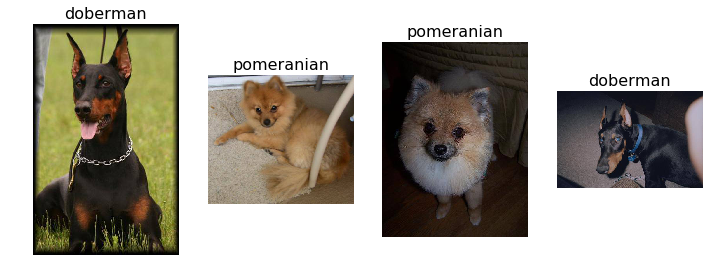

In [66]:
true_values_index = np.argmax(valid_labels, axis=1)
predicted_values_index = np.argmax(raw_valid_probs, axis=1)

highly_confident = (np.max(raw_valid_probs, axis=1) > 0.6)

correct = np.where(highly_confident & (true_values_index==predicted_values_index))[0]
print "Found %d correct labels" % len(correct)
idx = np.random.permutation(correct)[:n_view]
plots_idx(idx, titles=[valid_filenames[index][:-37] for index in idx])

**#2. A few incorrect labels at random**

Found 6 incorrect labels


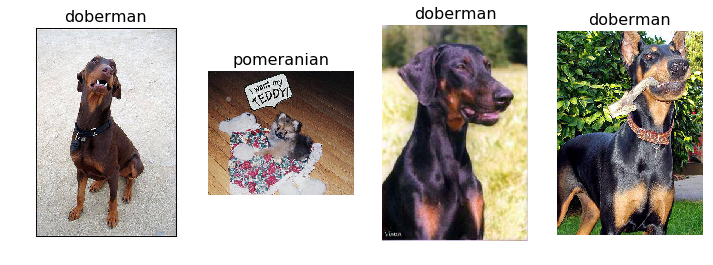

In [72]:
incorrect = np.where(np.argmax(valid_labels, axis=1)!=np.argmax(raw_valid_probs, axis=1))[0]
print "Found %d incorrect labels" % len(incorrect)
idx = np.random.permutation(incorrect)[:n_view]
plots_idx(idx, titles=[valid_filenames[index][:-37] for index in idx])

In [73]:
incorrect

array([ 1,  4,  5, 16, 17, 29])

In [81]:
valid_filenames[29]

'pomeranian/f8387071cbb4e77a274ab6035c3bb687.jpg'

In [90]:
raw_valid_probs[4]

array([ 0.16417995,  0.83582008], dtype=float32)

/home/denys/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


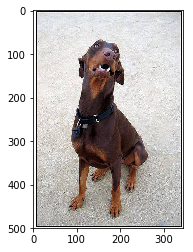

In [91]:
from scipy import ndimage

plt.imshow(ndimage.imread('data/sample/valid/'+ valid_filenames[4]))